In [1]:
import numpy as np
import pandas as pd
import datetime
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from creds import creds
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.tools as tls
import matplotlib.pyplot as plt
import datetime as dt
import math
from IPython.display import display, HTML
import seaborn as sns
%matplotlib inline 

pd.options.display.max_columns = 150

username = creds['username']
password = creds['password']
host = creds['host'] 
port = creds['port'] 
db_name = creds['db_name']

engine = create_engine( 'postgresql://{}:{}@{}:{}/{}'.format(username, 
                                                             password, 
                                                             host, 
                                                             port, 
                                                             db_name))
if not database_exists(engine.url):
    create_database(engine.url)
    
con = None
con = psycopg2.connect(database = db_name, user = username, host=host, password=password)
    
data_query = """
SELECT * FROM visa_data_table;
"""
visa_apps_all = pd.read_sql_query(data_query,con)
visa_apps_all = visa_apps_all.drop(columns=['index'])
display(visa_apps_all)

,decision_date,case_received_date,case_status,employer_num_employees,pw_amount_9089,pw_unit_of_pay_9089,wage_offer_from_9089,wage_offer_to_9089,wage_offer_unit_of_pay_9089,job_info_work_city,job_info_work_state,country_of_citizenship,fw_info_birth_country,class_of_admission,foreign_worker_info_education,foreign_worker_info_major,fw_info_yr_rel_edu_completed,foreign_worker_info_inst,naics_us_code,naics_us_title,pw_job_title_9089,pw_level_9089,agent_city,case_received_month,norm_salary,decision_days,sector_code
0,2015-03-10,2014-10-21,Certified-Expired,12443.0,"190,258.00",Year,"190,258.00","210,000.00",Year,San Francisco,CALIFORNIA,CHINA,CHINA,H-1B,Master's,COMPUTER SCIENCE,2008.0,UNIVERSITY OF ILLINOIS,454111,Electronic Shopping,Computer and Information Systems Managers,Level IV,Chicago,10.0,190258.0,140.0,45.0
1,2015-02-26,2014-10-01,Certified-Expired,72800.0,"113,027.00",Year,"120,000.00","145,400.00",Year,Cupertino,CALIFORNIA,INDIA,INDIA,H-1B,Master's,BUSINESS ADMINSTRATION,2012.0,"UNIVERISTY OF MICHIGAN, ANN ARBOR",334111,Electronic Computer Manufacturing,Logisticians,Level IV,San Francisco,10.0,113027.0,148.0,33.0
2,2015-05-07,2014-11-03,Certified,5875.0,"102,502.00",Year,"102,502.00",None,Year,MCLEAN,VIRGINIA,INDIA,INDIA,Parolee,Master's,INFORMATION SCIENCE,2005.0,NORTHEASTERN UNIVERSITY,541512,Computer Systems Design Services,Computer Systems Analysts,Level III,San Francisco,11.0,102502.0,185.0,54.0
3,2015-03-11,2014-10-22,Certified-Expired,46544.0,"93,579.00",Year,"95,000.00","175,400.00",Year,Hillsboro,OREGON,INDONESIA,INDONESIA,F-1,Doctorate,CHEMISTRY,2013.0,TEXAS A&M UNIVERSITY,3344,Semiconductor and Other Electronic Component M...,Materials Engineers,Level III,Phoenix,10.0,93579.0,140.0,33.0
4,2015-06-22,2014-12-23,Certified,1274.0,"116,376.00",Year,"200,000.00","255,000.00",Year,Springfield,MASSACHUSETTS,INDIA,INDIA,H-1B,Other,MEDICINE,2005.0,"UNIVERSITY OF DELHI, UNIVERSITY COLLEGE OF MED...",621111,Offices of Physicians (except Mental Health Sp...,"Internists, General",Level I,Northampton,12.0,116376.0,181.0,62.0
5,2015-03-11,2014-10-21,Certified-Expired,722.0,"69,514.00",Year,"70,000.00","75,000.00",Year,Armonk,NEW YORK,CHINA,CHINA,H-1B,Bachelor's,ACTUARIAL SCIENCE,2012.0,ST. JOHN'S UNIVERSITY,524126,Direct Property and Casualty Insurance Carriers,Actuaries,Level I,San Francisco,10.0,69514.0,141.0,52.0
6,2015-03-06,2014-10-08,Certified-Expired,1730.0,"84,906.00",Year,"84,906.00",None,Year,Rosemont,ILLINOIS,INDIA,INDIA,L-1,Bachelor's,MECHANICAL ENGINEERING,2004.0,RAJIV GANDHI COLLEGE OF ENGINEERING AND TECHNO...,541511,Custom Computer Programming Services,"Software developers, Applications",Level III,Chicago,10.0,84906.0,149.0,54.0
7,2015-03-02,2014-10-07,Certified-Expired,29000.0,"104,624.00",Year,"128,750.00",None,Year,FRANKLIN LAKES,NEW JERSEY,INDIA,INDIA,H-1B,Bachelor's,ELECTRICAL ENGINEERING,2004.0,UNIVERSITY OF MUMBAI,541710,"Research and Development in the Physical, Engi...",NETWORK AND COMPUTER SYSTEMS ADMINISTRATORS,Level IV,NEWARK,10.0,104624.0,146.0,54.0
8,2015-04-13,2014-10-31,Certified,200000.0,"62,982.00",Year,"93,000.00",None,Year,Buffalo Grove,ILLINOIS,INDIA,INDIA,H-1B,Master's,SOFTWARE ENGINEERING,2010.0,BIRLA INSTITUTE OF TECHNOLOGY,424210,Drugs and Druggists' Sundries Merchant Wholesa...,"Software Developers, Applications",Level II,McLean,10.0,62982.0,164.0,42.0
9,2015-03-19,2014-10-28,Certified-Expired,10.0,"101,858.00",Year,"103,000.00",None,Year,Beaverton,OREGON,SOUTH KOREA,SOUTH KOREA,B-2,Bachelor's,BUSINESS ADMINISTRATION,1995.0,CHUNG-ANG UNIVERSITY,7221,Full-Service Restaurants,Management Analysts,Level IV,Los Angeles,10.0,101858.0,142.0,72.0


In [37]:
#Combine multiple codes into one code for Manufacturing, 
#Retail Trade, and Transportation and Warehousing
visa_apps_all['sector_code'].replace(to_replace=33.0, value=31.0, inplace=True)
visa_apps_all['sector_code'].replace(to_replace=32.0, value=31.0, inplace=True)
visa_apps_all['sector_code'].replace(to_replace=45.0, value=44.0, inplace=True)
visa_apps_all['sector_code'].replace(to_replace=49.0, value=48.0, inplace=True)

Data read in- start Logistic Regression Tests

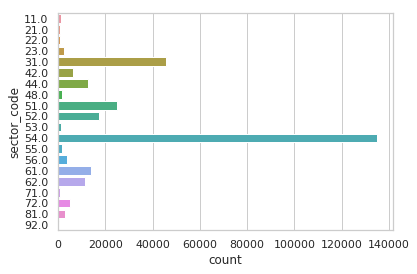

In [39]:
#Test logistic regression model- Sector Code histogram
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.countplot(y='sector_code', data=visa_apps_all)
plt.show()

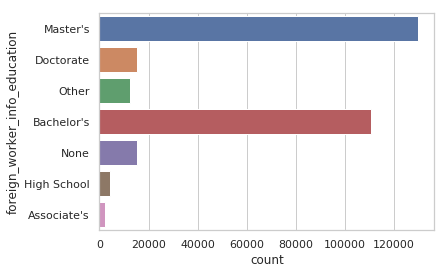

In [40]:
#Education Level Histogram
sns.countplot(y='foreign_worker_info_education', data=visa_apps_all)
plt.show()

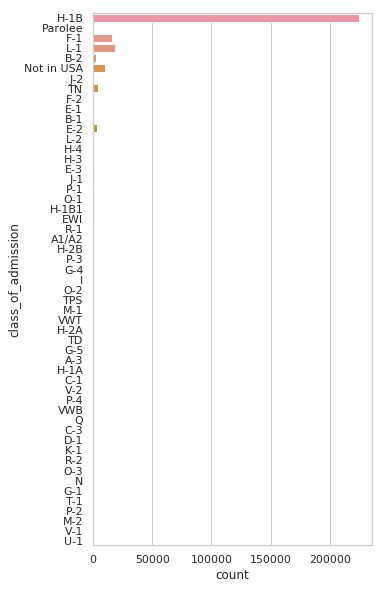

In [41]:
#Current Visa Status Histogram
plt.figure(figsize=(5,9.8))
sns.countplot(y='class_of_admission', data=visa_apps_all)
plt.show()

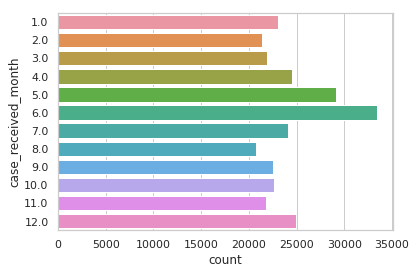

In [42]:
#Received month histogram
sns.countplot(y='case_received_month', data=visa_apps_all)
plt.show()

In [43]:
#Standardize the certifieds to include both expired and accepted cases
def standardize_certified(casestring):
    if 'Certified-Expired' == casestring:
        standardstring = 'Certified'
        #print(casestring, standardstring)
    else:
        standardstring = casestring
    return standardstring

In [44]:
#Filter out withdrawn applications- not interesting for our purposes
fitdata = visa_apps_all[visa_apps_all['case_status'] != 'Withdrawn']
fitdata_num = len(fitdata)
fitdata.index = range(fitdata_num)

#Add column for if agent used, standardize all certifieds to "Certified"
fitdata['case_status'] = fitdata.apply(lambda row: standardize_certified(row.case_status), axis=1)
fitdata['agent_used'] = np.where(pd.notnull(fitdata['agent_city']), 1, 0)

#Reduce to modeling variables and result
used_vars = ['case_status', 'case_received_month', 'class_of_admission', 'foreign_worker_info_education', 'sector_code']
used_vars2 = ['case_status', 'case_received_month', 'class_of_admission', 'foreign_worker_info_education', 'sector_code', 'agent_used']

fitdata_filter = fitdata[used_vars]
fitdata_filter2 = fitdata[used_vars2]
display(fitdata_filter.head())
display(fitdata_filter2.head())

/home/lauren/anaconda2/envs/insight_app/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/lauren/anaconda2/envs/insight_app/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,case_status,case_received_month,class_of_admission,foreign_worker_info_education,sector_code
0,Certified,10.0,H-1B,Master's,44.0
1,Certified,10.0,H-1B,Master's,31.0
2,Certified,11.0,Parolee,Master's,54.0
3,Certified,10.0,F-1,Doctorate,31.0
4,Certified,12.0,H-1B,Other,62.0


,case_status,case_received_month,class_of_admission,foreign_worker_info_education,sector_code,agent_used
0,Certified,10.0,H-1B,Master's,44.0,1
1,Certified,10.0,H-1B,Master's,31.0,1
2,Certified,11.0,Parolee,Master's,54.0,1
3,Certified,10.0,F-1,Doctorate,31.0,1
4,Certified,12.0,H-1B,Other,62.0,1


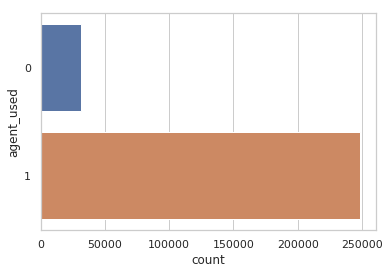

In [45]:
#Agent Used Histogram
sns.countplot(y='agent_used', data=fitdata_filter2)
plt.show()

,case_status_Certified,case_status_Denied,case_received_month_1.0,case_received_month_2.0,case_received_month_3.0,case_received_month_4.0,case_received_month_5.0,case_received_month_6.0,case_received_month_7.0,case_received_month_8.0,case_received_month_9.0,case_received_month_10.0,case_received_month_11.0,case_received_month_12.0,class_of_admission_A-3,class_of_admission_A1/A2,class_of_admission_B-1,class_of_admission_B-2,class_of_admission_C-1,class_of_admission_C-3,class_of_admission_D-1,class_of_admission_E-1,class_of_admission_E-2,class_of_admission_E-3,class_of_admission_EWI,class_of_admission_F-1,class_of_admission_F-2,class_of_admission_G-1,class_of_admission_G-4,class_of_admission_G-5,class_of_admission_H-1A,class_of_admission_H-1B,class_of_admission_H-1B1,class_of_admission_H-2A,class_of_admission_H-2B,class_of_admission_H-3,class_of_admission_H-4,class_of_admission_I,class_of_admission_J-1,class_of_admission_J-2,class_of_admission_K-1,class_of_admission_L-1,class_of_admission_L-2,class_of_admission_M-1,class_of_admission_M-2,class_of_admission_N,class_of_admission_Not in USA,class_of_admission_O-1,class_of_admission_O-2,class_of_admission_O-3,class_of_admission_P-1,class_of_admission_P-2,class_of_admission_P-3,class_of_admission_P-4,class_of_admission_Parolee,class_of_admission_Q,class_of_admission_R-1,class_of_admission_R-2,class_of_admission_T-1,class_of_admission_TD,class_of_admission_TN,class_of_admission_TPS,class_of_admission_U-1,class_of_admission_V-1,class_of_admission_V-2,class_of_admission_VWB,class_of_admission_VWT,foreign_worker_info_education_Associate's,foreign_worker_info_education_Bachelor's,foreign_worker_info_education_Doctorate,foreign_worker_info_education_High School,foreign_worker_info_education_Master's,foreign_worker_info_education_None,foreign_worker_info_education_Other,sector_code_11.0,sector_code_21.0,sector_code_22.0,sector_code_23.0,sector_code_31.0,sector_code_42.0,sector_code_44.0,sector_code_48.0,sector_code_51.0,sector_code_52.0,sector_code_53.0,sector_code_54.0,sector_code_55.0,sector_code_56.0,sector_code_61.0,sector_code_62.0,sector_code_71.0,sector_code_72.0,sector_code_81.0,sector_code_92.0
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


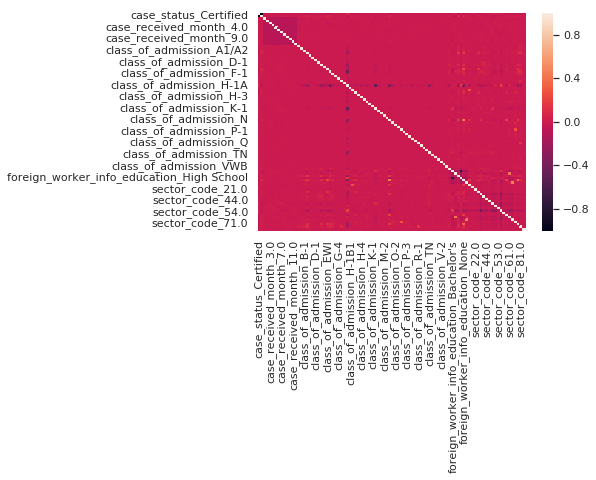

In [46]:
#Train Logistic Regression Model
#Time to train the model! Use basic model- only a couple of variables
#Create dummy variables
dummy_data = pd.get_dummies(fitdata_filter, columns=used_vars)
display(dummy_data.head())

#List columns and check variable independence
dummy_data.columns
sns.heatmap(dummy_data.corr())
plt.show()

In [47]:
#Load in regression packages
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

#Split data for validation
X = dummy_data.iloc[:, 2:]
y = dummy_data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape

#Fit logistic regression to training set
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

#Predict test set results and create confusion matrix
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
#from sklearn import predict_proba
logreg_confuse = confusion_matrix(y_test, y_pred)
display(logreg_confuse)

print('Actual number denied in test set: ' + str(len(y_test) - np.sum(y_test)))
print('Actual number denied in training set: ' + str(len(y_train) - np.sum(y_train)))
print('Actual number certified in test set: ' + str(np.sum(y_test)))
print('Actual number certified in training set: ' + str(np.sum(y_train)))

score = classifier.score(X_test, y_test)
print('Classifier Score:' + str(score))

#testprob = classifier.predict_proba(X_test)
#print(testprob)
#print(y_test)
#display(X_train.columns)
print(classifier.coef_[0])



array([[   12,  3484],
       [   20, 66269]])

Actual number denied in test set: 3496
Actual number denied in training set: 10039
Actual number certified in test set: 66289
Actual number certified in training set: 199313
Classifier Score:0.9497886365264742
[ 0.07340216  0.16321253  0.35446962  0.19878011  0.24659974 -0.00338817
  0.05916231 -0.10470831 -0.19337312  0.25938185  0.151932    0.19000937
 -1.52154094  0.18298676 -0.94077681 -0.28943348 -0.76509756 -0.99398462
 -0.86616225  0.23320268  0.31826455  0.46030027 -1.09806041  0.41125298
  0.27959295 -0.04725878  1.00399822  0.27358792  0.09130054  0.96856915
 -0.26823254 -1.59921125 -0.67649006  0.75268257  0.68316982 -0.05891166
  0.39393755  1.08413795 -0.75671545  1.61314015  0.8091645   0.13785523
 -0.56175698  0.2274369   0.129615    0.71313727 -0.60086472 -0.00482628
  0.47543109  0.05059509  0.15519873 -0.08194131  0.70171823  0.46922276
  0.62426189 -0.43025236  0.07337878  0.77437061  1.00666748  0.34081093
  0.         -0.65469604 -0.52129077 -0.53997556 -0.76602863

In [48]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print(classification_report(y_train, classifier.predict(X_train)))

Accuracy of logistic regression classifier on test set: 0.95
             precision    recall  f1-score   support

          0       0.38      0.00      0.01      3496
          1       0.95      1.00      0.97     66289

avg / total       0.92      0.95      0.93     69785

             precision    recall  f1-score   support

          0       0.52      0.01      0.01     10039
          1       0.95      1.00      0.98    199313

avg / total       0.93      0.95      0.93    209352



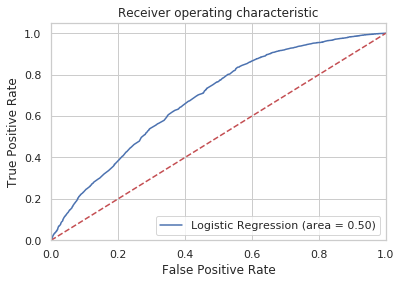

0.5015653925483287

In [49]:
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

display(logit_roc_auc)

Logistic Regression Complete- start Neural Network training. Can use X_train, y_train, X_test, and y_tests from logistic regression fit to start with

In [50]:
#Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

In [51]:
#Setup and fit neural network
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train_scale,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [52]:
#Predictions and evaluation
predictions = mlp.predict(X_test_scale)
#print(type(y_test), type(predictions))

print('Actual number denied in test set: ' + str(len(y_test) - np.sum(y_test)))
print('Actual number denied in training set: ' + str(len(y_train) - np.sum(y_train)))
print('Actual number certified in test set: ' + str(np.sum(y_test)))
print('Actual number certified in training set: ' + str(np.sum(y_train)))
mlp_confusion = confusion_matrix(y_test,predictions)
display(mlp_confusion)
print(classification_report(y_test,predictions))

Actual number denied in test set: 3496
Actual number denied in training set: 10039
Actual number certified in test set: 66289
Actual number certified in training set: 199313


array([[  117,  3379],
       [  195, 66094]])

             precision    recall  f1-score   support

          0       0.38      0.03      0.06      3496
          1       0.95      1.00      0.97     66289

avg / total       0.92      0.95      0.93     69785



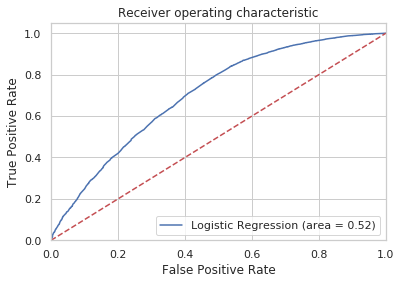

In [53]:
mlp_roc_auc = roc_auc_score(y_test, mlp.predict(X_test_scale))
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test_scale)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % mlp_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


Neural Network not performing significantly better- try adding agent/no agent factor

,case_status_Certified,case_status_Denied,case_received_month_1.0,case_received_month_2.0,case_received_month_3.0,case_received_month_4.0,case_received_month_5.0,case_received_month_6.0,case_received_month_7.0,case_received_month_8.0,case_received_month_9.0,case_received_month_10.0,case_received_month_11.0,case_received_month_12.0,class_of_admission_A-3,class_of_admission_A1/A2,class_of_admission_B-1,class_of_admission_B-2,class_of_admission_C-1,class_of_admission_C-3,class_of_admission_D-1,class_of_admission_E-1,class_of_admission_E-2,class_of_admission_E-3,class_of_admission_EWI,class_of_admission_F-1,class_of_admission_F-2,class_of_admission_G-1,class_of_admission_G-4,class_of_admission_G-5,class_of_admission_H-1A,class_of_admission_H-1B,class_of_admission_H-1B1,class_of_admission_H-2A,class_of_admission_H-2B,class_of_admission_H-3,class_of_admission_H-4,class_of_admission_I,class_of_admission_J-1,class_of_admission_J-2,class_of_admission_K-1,class_of_admission_L-1,class_of_admission_L-2,class_of_admission_M-1,class_of_admission_M-2,class_of_admission_N,class_of_admission_Not in USA,class_of_admission_O-1,class_of_admission_O-2,class_of_admission_O-3,class_of_admission_P-1,class_of_admission_P-2,class_of_admission_P-3,class_of_admission_P-4,class_of_admission_Parolee,class_of_admission_Q,class_of_admission_R-1,class_of_admission_R-2,class_of_admission_T-1,class_of_admission_TD,class_of_admission_TN,class_of_admission_TPS,class_of_admission_U-1,class_of_admission_V-1,class_of_admission_V-2,class_of_admission_VWB,class_of_admission_VWT,foreign_worker_info_education_Associate's,foreign_worker_info_education_Bachelor's,foreign_worker_info_education_Doctorate,foreign_worker_info_education_High School,foreign_worker_info_education_Master's,foreign_worker_info_education_None,foreign_worker_info_education_Other,sector_code_11.0,sector_code_21.0,sector_code_22.0,sector_code_23.0,sector_code_31.0,sector_code_42.0,sector_code_44.0,sector_code_48.0,sector_code_51.0,sector_code_52.0,sector_code_53.0,sector_code_54.0,sector_code_55.0,sector_code_56.0,sector_code_61.0,sector_code_62.0,sector_code_71.0,sector_code_72.0,sector_code_81.0,sector_code_92.0,agent_used_1
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


(279137, 95)
Index(['case_status_Certified', 'case_status_Denied',
       'case_received_month_1.0', 'case_received_month_2.0',
       'case_received_month_3.0', 'case_received_month_4.0',
       'case_received_month_5.0', 'case_received_month_6.0',
       'case_received_month_7.0', 'case_received_month_8.0',
       'case_received_month_9.0', 'case_received_month_10.0',
       'case_received_month_11.0', 'case_received_month_12.0',
       'class_of_admission_A-3', 'class_of_admission_A1/A2',
       'class_of_admission_B-1', 'class_of_admission_B-2',
       'class_of_admission_C-1', 'class_of_admission_C-3',
       'class_of_admission_D-1', 'class_of_admission_E-1',
       'class_of_admission_E-2', 'class_of_admission_E-3',
       'class_of_admission_EWI', 'class_of_admission_F-1',
       'class_of_admission_F-2', 'class_of_admission_G-1',
       'class_of_admission_G-4', 'class_of_admission_G-5',
       'class_of_admission_H-1A', 'class_of_admission_H-1B',
       'class_of_admission_H-

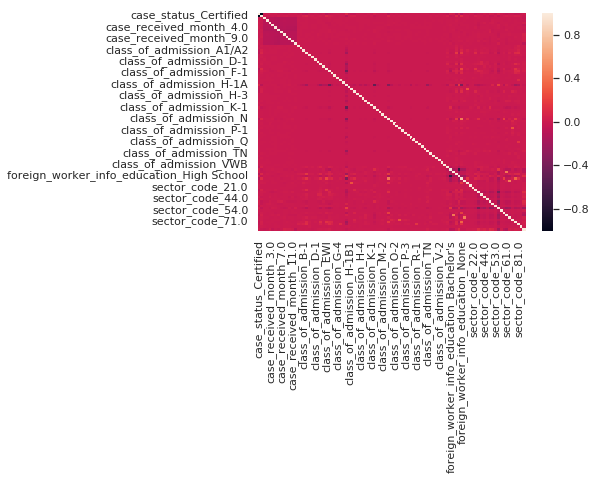

(209352, 93)

In [54]:
#Logistic reg, agent/no agent factor added
dummy_data2 = pd.get_dummies(fitdata_filter2, columns=used_vars2)
dummy_data2.drop(columns=['agent_used_0'], inplace=True)
display(dummy_data2.head())
print(dummy_data2.shape)

#List columns and check variable independence
print(dummy_data2.columns)
sns.heatmap(dummy_data2.corr())
plt.show()

#Split data for validation
X2 = dummy_data2.iloc[:, 2:]
y2 = dummy_data2.iloc[:, 0]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=0)
X_train2.shape
#display(X2, y2)

array([[    0,  3496],
       [    0, 66289]])

Actual number denied in test set: 3496
Actual number denied in training set: 10039
Actual number certified in test set: 66289
Actual number certified in training set: 199313
Classifier Score:0.9499032743426238
[ 8.09027182e-02  1.08996982e-01  1.79053321e-01  1.34124343e-01
  1.61794316e-01  6.83055128e-02  8.89716928e-02 -1.15452988e-02
 -4.64393741e-02  1.27935389e-01  1.07750913e-01  1.46727321e-01
 -5.29427467e-03 -3.82685800e-04 -6.20873320e-02 -1.15005006e-01
 -4.55090043e-03 -2.12496995e-03 -1.37557635e-03 -6.23429291e-04
  2.17594435e-02  1.66269916e-02 -1.66452704e-01  1.19974252e-01
  8.05726527e-03 -1.59107202e-04  4.30671838e-03  3.79841652e-04
  1.28980011e-04  7.18935625e-01 -1.05617643e-02 -2.78719572e-02
 -3.93087016e-02  1.61821786e-03  1.44672704e-02 -7.70674478e-04
  1.29378200e-02  5.26187467e-03 -8.36325487e-04  4.69587840e-01
  1.42751868e-02 -1.10229452e-04 -7.04204727e-04  3.05486706e-04
  2.09961847e-02  2.02459952e-02 -1.06806879e-03 -2.71326334e-04
 -6.603970

/home/lauren/anaconda2/envs/insight_app/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3496
          1       0.95      1.00      0.97     66289

avg / total       0.90      0.95      0.93     69785

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     10039
          1       0.95      1.00      0.98    199313

avg / total       0.91      0.95      0.93    209352



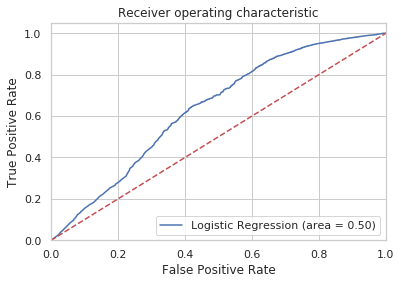

In [55]:
#Fit logistic regression to training set
logreg_2 = LogisticRegression(C=0.001, class_weight=None, max_iter=50000)
logreg_2.fit(X_train2, y_train2)

#Predict test set results and create confusion matrix
y_pred2 = logreg_2.predict(X_test2)
logreg_confuse2 = confusion_matrix(y_test2, y_pred2)
display(logreg_confuse2)

print('Actual number denied in test set: ' + str(len(y_test2) - np.sum(y_test2)))
print('Actual number denied in training set: ' + str(len(y_train2) - np.sum(y_train2)))
print('Actual number certified in test set: ' + str(np.sum(y_test2)))
print('Actual number certified in training set: ' + str(np.sum(y_train2)))

score2 = logreg_2.score(X_test2, y_test2)
print('Classifier Score:' + str(score2))

#testprob = classifier.predict_proba(X_test)
#print(testprob)
#print(y_test)
#display(X_train.columns)
print(logreg_2.coef_[0])

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_2.score(X_test2, y_test2)))

print(classification_report(y_test2, y_pred2))

print(classification_report(y_train2, logreg_2.predict(X_train2)))

logit2_roc_auc = roc_auc_score(y_test2, logreg_2.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, logreg_2.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#display(logit_roc_auc)

In [56]:
#Try Neural Network
#Scale the data
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train2)

# Now apply the transformations to the data:
X_train2_scale = scaler.transform(X_train2)
X_test2_scale = scaler.transform(X_test2)

#Setup and fit neural network
mlp2 = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp2.fit(X_train2_scale,y_train2)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Actual number denied in test set: 3496
Actual number denied in training set: 10039
Actual number certified in test set: 66289
Actual number certified in training set: 199313


array([[   94,  3402],
       [  100, 66189]])

             precision    recall  f1-score   support

          0       0.48      0.03      0.05      3496
          1       0.95      1.00      0.97     66289

avg / total       0.93      0.95      0.93     69785



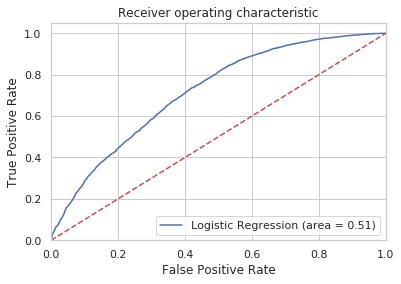

In [57]:
#Predictions and evaluation
predictions2 = mlp2.predict(X_test2_scale)
#print(type(y_test), type(predictions))

print('Actual number denied in test set: ' + str(len(y_test2) - np.sum(y_test2)))
print('Actual number denied in training set: ' + str(len(y_train2) - np.sum(y_train2)))
print('Actual number certified in test set: ' + str(np.sum(y_test2)))
print('Actual number certified in training set: ' + str(np.sum(y_train2)))
mlp_confusion2 = confusion_matrix(y_test2,predictions2)
display(mlp_confusion2)
print(classification_report(y_test2,predictions2))

mlp2_roc_auc = roc_auc_score(y_test2, mlp2.predict(X_test2_scale))
fpr, tpr, thresholds = roc_curve(y_test2, mlp2.predict_proba(X_test2_scale)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % mlp2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Neural Network and Logistic Regression not improved by adding agent/no agent, try Random Forest

In [68]:
# Import the model
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf2 = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)
rf2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Accuracy: 0.948599269183922
Accuracy: 0.948699577273053


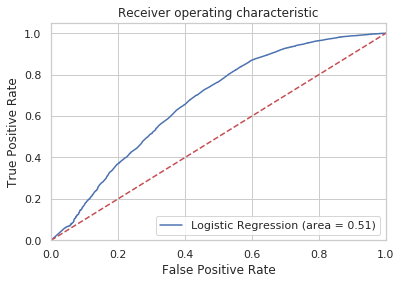

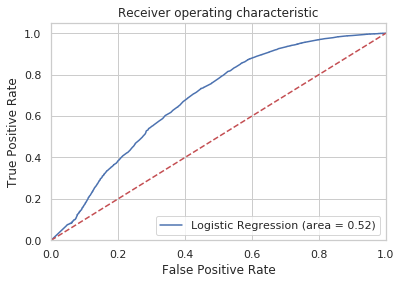

In [70]:
# Use the forest's predict method on the test data
rf_pred = rf.predict(X_test)
rf_pred2 = rf2.predict(X_test2)

#Evaluation Metrics
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, rf_pred))
print("Accuracy:", metrics.accuracy_score(y_test2, rf_pred2))

rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

rf2_roc_auc = roc_auc_score(y_test2, rf2.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, rf2.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rf2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Additional factor not helpful in any model, reduce dimensionality of visa factor to H-1B, Not in USA, and Other Visa

,case_status,case_received_month,foreign_worker_info_education,sector_code,agent_used,visa_type
0,Certified,10.0,Master's,44.0,1,H-1B
1,Certified,10.0,Master's,31.0,1,H-1B
2,Certified,11.0,Master's,54.0,1,Other
3,Certified,10.0,Doctorate,31.0,1,Other
4,Certified,12.0,Other,62.0,1,H-1B


,case_status_Certified,case_status_Denied,case_received_month_1.0,case_received_month_2.0,case_received_month_3.0,case_received_month_4.0,case_received_month_5.0,case_received_month_6.0,case_received_month_7.0,case_received_month_8.0,case_received_month_9.0,case_received_month_10.0,case_received_month_11.0,case_received_month_12.0,visa_type_H-1B,visa_type_Not in USA,visa_type_Other,foreign_worker_info_education_Associate's,foreign_worker_info_education_Bachelor's,foreign_worker_info_education_Doctorate,foreign_worker_info_education_High School,foreign_worker_info_education_Master's,foreign_worker_info_education_None,foreign_worker_info_education_Other,sector_code_11.0,sector_code_21.0,sector_code_22.0,sector_code_23.0,sector_code_31.0,sector_code_42.0,sector_code_44.0,sector_code_48.0,sector_code_51.0,sector_code_52.0,sector_code_53.0,sector_code_54.0,sector_code_55.0,sector_code_56.0,sector_code_61.0,sector_code_62.0,sector_code_71.0,sector_code_72.0,sector_code_81.0,sector_code_92.0,agent_used_1
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


(279137, 45)
Index(['case_status_Certified', 'case_status_Denied',
       'case_received_month_1.0', 'case_received_month_2.0',
       'case_received_month_3.0', 'case_received_month_4.0',
       'case_received_month_5.0', 'case_received_month_6.0',
       'case_received_month_7.0', 'case_received_month_8.0',
       'case_received_month_9.0', 'case_received_month_10.0',
       'case_received_month_11.0', 'case_received_month_12.0',
       'visa_type_H-1B', 'visa_type_Not in USA', 'visa_type_Other',
       'foreign_worker_info_education_Associate's',
       'foreign_worker_info_education_Bachelor's',
       'foreign_worker_info_education_Doctorate',
       'foreign_worker_info_education_High School',
       'foreign_worker_info_education_Master's',
       'foreign_worker_info_education_None',
       'foreign_worker_info_education_Other', 'sector_code_11.0',
       'sector_code_21.0', 'sector_code_22.0', 'sector_code_23.0',
       'sector_code_31.0', 'sector_code_42.0', 'sector_code_44.0

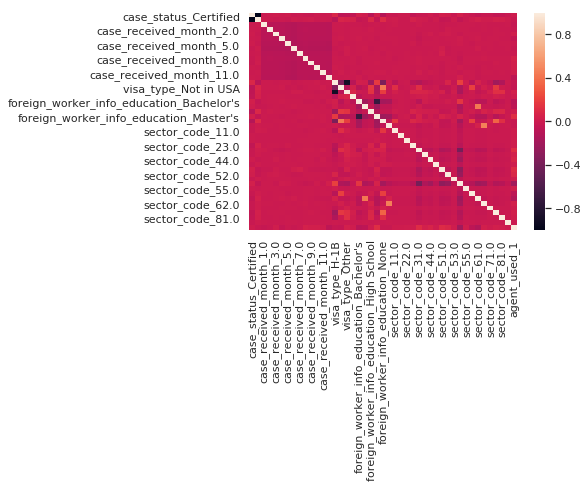

(209352, 43)

In [59]:
fitdata_filter_reduce = fitdata_filter2.copy()
fitdata_filter_reduce['visa_type'] = np.where(((fitdata_filter_reduce['class_of_admission']!= 'H-1B' )
                                               & (fitdata_filter_reduce['class_of_admission'] != 'Not in USA'))
                                              , 'Other', fitdata_filter_reduce['class_of_admission'])
fitdata_filter_reduce.drop(columns='class_of_admission', inplace=True)
display(fitdata_filter_reduce.head())

#Preprocess data for logistic regression
used_vars_reduce = ['case_status', 'case_received_month', 'visa_type', 
                    'foreign_worker_info_education', 'sector_code', 'agent_used']
dummy_data_reduce = pd.get_dummies(fitdata_filter_reduce, columns=used_vars_reduce)
dummy_data_reduce.drop(columns=['agent_used_0'], inplace=True)
display(dummy_data_reduce.head())
print(dummy_data_reduce.shape)

#List columns and check variable independence
print(dummy_data_reduce.columns)
sns.heatmap(dummy_data_reduce.corr())
plt.show()

#Split data for validation
X_reduce = dummy_data_reduce.iloc[:, 2:]
y_reduce = dummy_data_reduce.iloc[:, 0]
X_train_reduce, X_test_reduce, y_train_reduce, y_test_reduce = train_test_split(X_reduce, y_reduce, test_size=0.25, random_state=0)
X_train_reduce.shape

In [115]:
#Set model weights
totalnum = len(y_train)
totaccept = y_train.sum()
totdenied = totalnum - totaccept
weight_accept = totdenied / (totalnum)
weight_denied = totaccept / (totalnum)
class_weights = {0: weight_denied, 1: weight_accept}
display(class_weights)

{0: 0.9520472696702205, 1: 0.04795273032977951}

array([[ 1744,  1752],
       [15444, 50845]])

Actual number denied in test set: 3496
Actual number denied in training set: 10039
Actual number certified in test set: 66289
Actual number certified in training set: 199313
Classifier Score:0.7535860141864298
[-1.09070610e-01  4.63978187e-02  2.01942844e-01  4.63794073e-02
  8.82265572e-02 -1.29649293e-01 -8.70042429e-02 -2.91702035e-01
 -3.61147308e-01  4.96333834e-02  1.04162249e-03  6.65972461e-02
  1.13063227e-01 -4.31594286e-01 -1.59823550e-01 -1.02969784e+00
  4.25034301e-01  1.19974413e+00 -9.83861347e-01  3.73562876e-01
 -5.54618636e-01  3.40749383e-01 -2.13775065e-01  1.33151975e-01
  5.22512708e-01 -6.20847617e-01  1.68551034e-01 -4.44204280e-02
  5.29249830e-01 -1.96989550e-01  7.82917817e-01  7.69807200e-01
 -4.93334193e-01  2.33426677e-01  3.80421519e-01  1.62521880e-01
 -8.57096200e-01 -2.68002030e-01 -2.47738297e-01  2.73143790e-02
 -3.21228698e-01 -9.24797550e-01  1.01542250e-01]
Accuracy of logistic regression classifier on test set: 0.75
             precision    rec

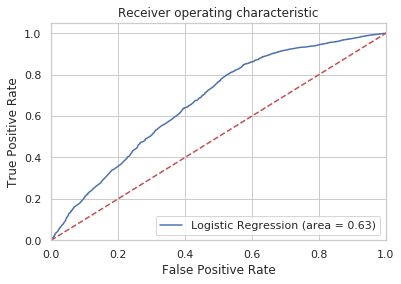

In [121]:
#Fit logistic regression to training set
logreg_reduce = LogisticRegression(C=0.5, class_weight=class_weights, max_iter=500000)
logreg_reduce.fit(X_train_reduce, y_train_reduce)

#Predict test set results and create confusion matrix
y_pred_reduce = logreg_reduce.predict(X_test_reduce)
logreg_confuse_reduce = confusion_matrix(y_test_reduce, y_pred_reduce)
display(logreg_confuse_reduce)

print('Actual number denied in test set: ' + str(len(y_test_reduce) - np.sum(y_test_reduce)))
print('Actual number denied in training set: ' + str(len(y_train_reduce) - np.sum(y_train_reduce)))
print('Actual number certified in test set: ' + str(np.sum(y_test_reduce)))
print('Actual number certified in training set: ' + str(np.sum(y_train_reduce)))

score_reduce = logreg_reduce.score(X_test_reduce, y_test_reduce)
print('Classifier Score:' + str(score_reduce))

#testprob = classifier.predict_proba(X_test)
#print(testprob)
#print(y_test)
#display(X_train.columns)
print(logreg_reduce.coef_[0])

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_reduce.score(X_test_reduce, y_test_reduce)))

print(classification_report(y_test_reduce, y_pred_reduce))

print(classification_report(y_train_reduce, logreg_reduce.predict(X_train_reduce)))

logit_roc_auc_reduce = roc_auc_score(y_test_reduce, logreg_reduce.predict(X_test_reduce))
fpr, tpr, thresholds = roc_curve(y_test_reduce, logreg_reduce.predict_proba(X_test_reduce)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_reduce)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
#Try Neural Network
#Scale the data
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train_reduce)

# Now apply the transformations to the data:
X_train_reduce_scale = scaler.transform(X_train_reduce)
X_test_reduce_scale = scaler.transform(X_test_reduce)

#Setup and fit neural network
mlp_reduce = MLPClassifier(hidden_layer_sizes=(100,100,100, 100, 100), alpha=0.0000001, 
                           learning_rate='adaptive', max_iter=1000000)
mlp_reduce.fit(X_train_reduce_scale,y_train_reduce)

#Predictions and evaluation
predictions_reduce = mlp_reduce.predict(X_test_reduce_scale)
#print(type(y_test), type(predictions))

print('Actual number denied in test set: ' + str(len(y_test_reduce) - np.sum(y_test_reduce)))
print('Actual number denied in training set: ' + str(len(y_train_reduce) - np.sum(y_train_reduce)))
print('Actual number certified in test set: ' + str(np.sum(y_test_reduce)))
print('Actual number certified in training set: ' + str(np.sum(y_train_reduce)))
mlp_confusion_reduce = confusion_matrix(y_test_reduce,predictions_reduce)
display(mlp_confusion_reduce)
print(classification_report(y_test_reduce,predictions_reduce))

mlp_reduce_roc_auc = roc_auc_score(y_test_reduce, mlp_reduce.predict(X_test_reduce_scale))
fpr, tpr, thresholds = roc_curve(y_test_reduce, mlp_reduce.predict_proba(X_test_reduce_scale)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % mlp_reduce_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [126]:
#Output model to sql
model_dataframe = pd.DataFrame(logreg_reduce.coef_, columns=X_reduce.columns)
display(model_dataframe)
model_dataframe.to_sql('model_coeff_table', engine, if_exists='replace')

,case_received_month_1.0,case_received_month_2.0,case_received_month_3.0,case_received_month_4.0,case_received_month_5.0,case_received_month_6.0,case_received_month_7.0,case_received_month_8.0,case_received_month_9.0,case_received_month_10.0,case_received_month_11.0,case_received_month_12.0,visa_type_H-1B,visa_type_Not in USA,visa_type_Other,foreign_worker_info_education_Associate's,foreign_worker_info_education_Bachelor's,foreign_worker_info_education_Doctorate,foreign_worker_info_education_High School,foreign_worker_info_education_Master's,foreign_worker_info_education_None,foreign_worker_info_education_Other,sector_code_11.0,sector_code_21.0,sector_code_22.0,sector_code_23.0,sector_code_31.0,sector_code_42.0,sector_code_44.0,sector_code_48.0,sector_code_51.0,sector_code_52.0,sector_code_53.0,sector_code_54.0,sector_code_55.0,sector_code_56.0,sector_code_61.0,sector_code_62.0,sector_code_71.0,sector_code_72.0,sector_code_81.0,sector_code_92.0,agent_used_1
0,-0.109071,0.046398,0.201943,0.046379,0.088227,-0.129649,-0.087004,-0.291702,-0.361147,0.049633,0.001042,0.066597,0.113063,-0.431594,-0.159824,-1.029698,0.425034,1.199744,-0.983861,0.373563,-0.554619,0.340749,-0.213775,0.133152,0.522513,-0.620848,0.168551,-0.04442,0.52925,-0.19699,0.782918,0.769807,-0.493334,0.233427,0.380422,0.162522,-0.857096,-0.268002,-0.247738,0.027314,-0.321229,-0.924798,0.101542
